In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

from tqdm.auto import tqdm
from multiprocessing import Pool
import re

import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

In [2]:
filename = '../data/20240825_minflux_L-sweep_raw.h5'
saved = nl.io.load.hdf5(filename)

In [3]:
data       = saved['data']
conditions = saved['conditions']

In [4]:
Ls = np.array([int(re.search('L(\d+)$', cond)[1]) for cond in conditions])
print(Ls)
print(conditions)

[ 30  40 100 150 175 200 250]
['L30', 'L40', 'L100', 'L150', 'L175', 'L200', 'L250']


In [5]:
colors = {cond : plt.cm.viridis(i/(len(conditions)-1)) for i, cond in enumerate(conditions)}

In [7]:
# Ultimately we will discard any (filtered & cut) trajectory shorter
# than 1K frames, so might as well do it here also, for convenience
data.makeSelection()
uncut = len(data)
data.makeSelection(lambda traj, _: traj.F < 1000)
data.deleteSelection()

print(f"{len(data)}/{uncut} trajectories left")

1298/4442 trajectories left


# Plot MSDs

L30 210


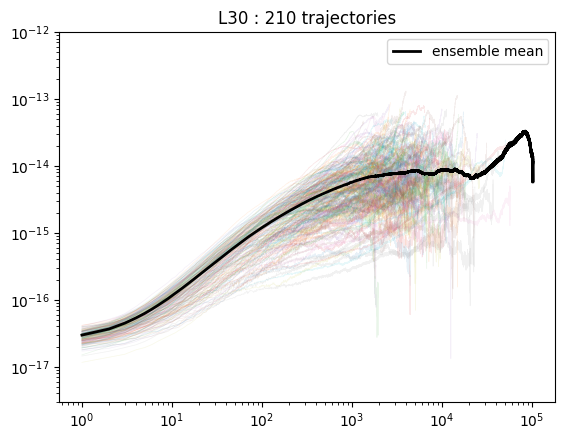

L40 218


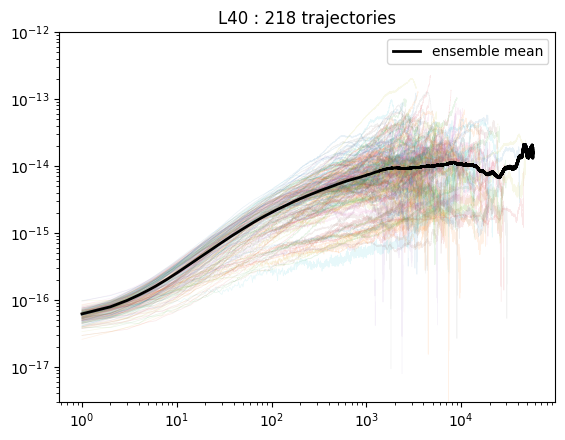

L100 232


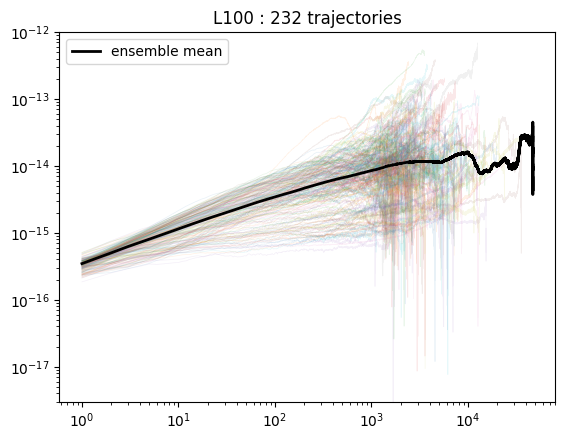

L150 173


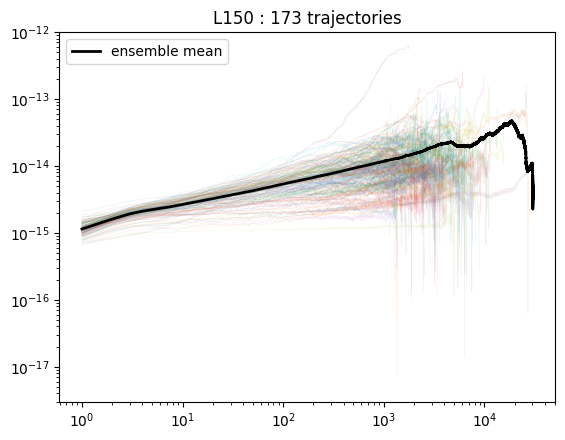

L175 161


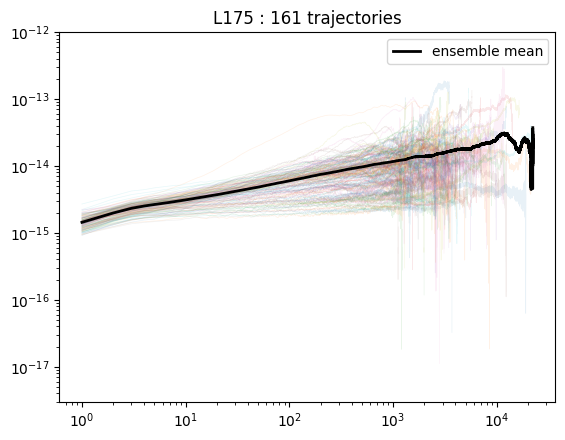

L200 176


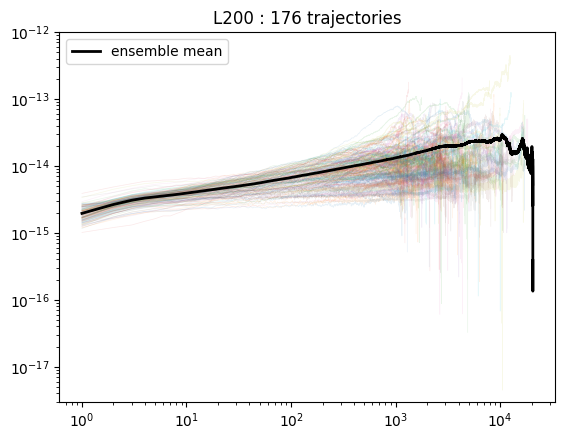

L250 128


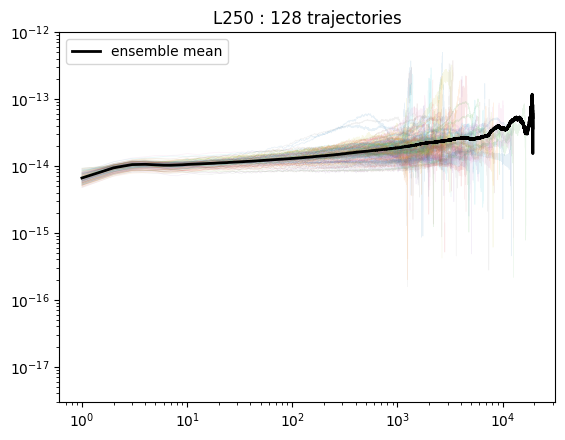

In [8]:
for cond in conditions:
    data.makeSelection(cond)
    print(cond, len(data))

    nl.plot.msd_overview(data, linewidth=0.5, alpha=0.1)
    plt.title(f'{cond} : {len(data)} trajectories')
    plt.ylim([3e-18, 1e-12])
    plt.show()

# Filtering background trajectories
Copied from array cleaning; there's not much background here for the most part, so this doesn't do too much. Still a good idea to chop off the odd ends and kick out the few background traces that there are.

In [9]:
# Technical check, since we assume below that first and last frame are valid
data.makeSelection()
for traj in data:
    assert not np.any(np.isnan(traj[[0, -1]]))

In [10]:
plotting = False # set to True for plotting

data_valid = nl.TaggedSet()

data.makeSelection()
data.refineSelection(lambda traj, _: traj.F > 1000)
filetags = sorted({tag for tag in data.tagset() if tag.startswith('file=')})
for tag in tqdm(filetags):
    data.makeSelection(tag)
    data.refineSelection(lambda traj, _: traj.F > 1000)
    
    if plotting:
        fig, axs = plt.subplots(1, 2, figsize=[10, 4],
                                gridspec_kw={'width_ratios' : [4, 6]},
                               )
    
        t0 = 0
        off_x, off_y = data[0][0]
        off_y += 1e-6 # get an offset between the coordinates
        
    for i, (traj, tags) in enumerate(data(giveTags=True)):
        # Cut off background
        i_valid = np.nonzero(~np.isnan(traj.abs()[:]))[0]
        frames = traj[i_valid]
        med = np.median(frames, axis=0)
        above = frames > med[None, :]
        ind_crossing_x = np.nonzero(np.diff(above[:, 0]))[0]
        ind_crossing_y = np.nonzero(np.diff(above[:, 1]))[0]
        
        ind_start = max(ind_crossing_x[ 0]+1, ind_crossing_y[ 0]+1)
        ind_end   = min(ind_crossing_x[-1],   ind_crossing_y[-1]) #- len(frames)
        if ind_end > ind_start:
            t_start = i_valid[ind_start]
            t_end   = i_valid[ind_end  ]+1
            traj_valid = nl.Trajectory(traj[t_start:t_end], dt=traj.meta['dt'])
        else:
            traj_valid = None
        
        if traj_valid is not None:
            data_valid.add(traj_valid, tags)
        
        if plotting:
            ax = axs[0]
            nl.plot.spatial(traj, ax=ax, color='gray', alpha=0.5)# label=f'{i} | ')
            if traj_valid is not None:
                nl.plot.spatial(traj_valid, ax=ax, label=f'{i} | ')

            ax = axs[1]
            ind_valid = np.nonzero(~np.isnan(traj.abs()[:][:, 0]))[0]
            h = ax.plot(t0 + ind_valid, traj[ind_valid][:, 0] - off_x, color='gray', alpha=0.5)
            h = ax.plot(t0 + ind_valid, traj[ind_valid][:, 1] - off_y,
                        color=h[0].get_color(), alpha=0.5,
                       )
            if traj_valid is not None:
                ind = np.nonzero(~np.isnan(traj_valid.abs()[:][:, 0]))[0]
                h = ax.plot(t0 + t_start + ind, traj_valid[ind][:, 0] - off_x)
                h = ax.plot(t0 + t_start + ind, traj_valid[ind][:, 1] - off_y,
                            color=h[0].get_color(),
                           )

            t0 += ind_valid[-1] + 1

    if plotting:
        ax = axs[0]
        ax.axis('square')

        plt.show()

  0%|          | 0/88 [00:00<?, ?it/s]

In [11]:
data_valid.makeSelection(lambda traj, _: traj.F < 1000)
data_valid.deleteSelection()
print(len(data_valid), 'valid trajectories')

with nl.Parallelize():
    _ = nl.analysis.MSD(data_valid, chunksize=1, show_progress=True)

1085 valid trajectories


  0%|          | 0/1085 [00:00<?, ?it/s]

L30 142


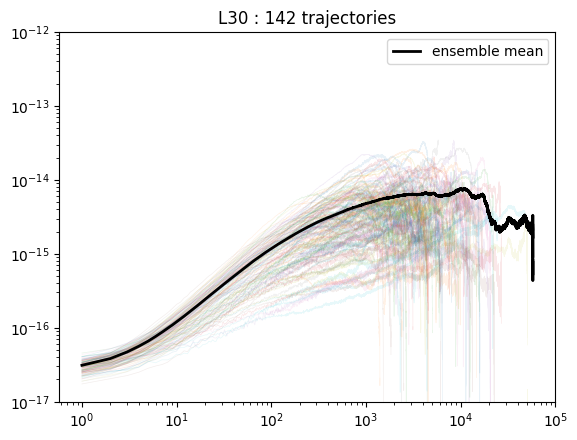

L40 157


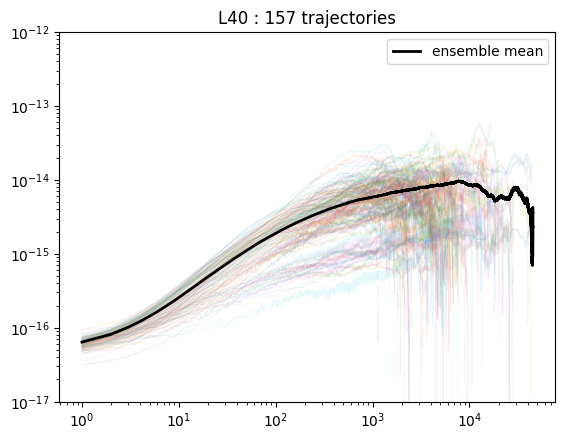

L100 193


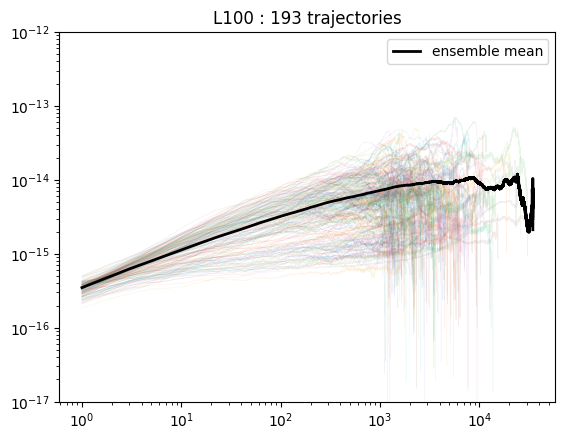

L150 159


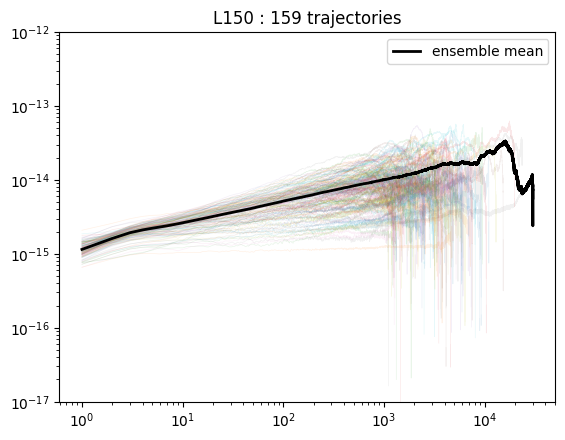

L175 150


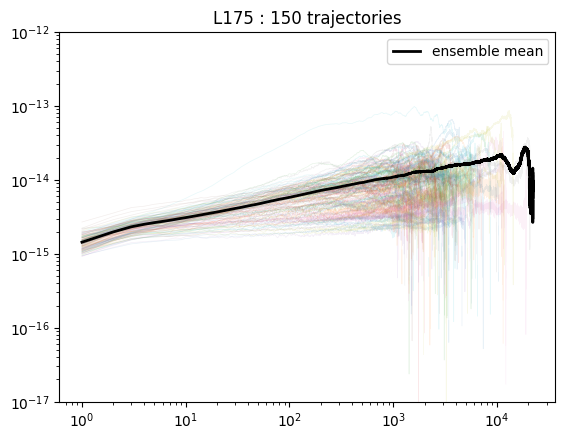

L200 160


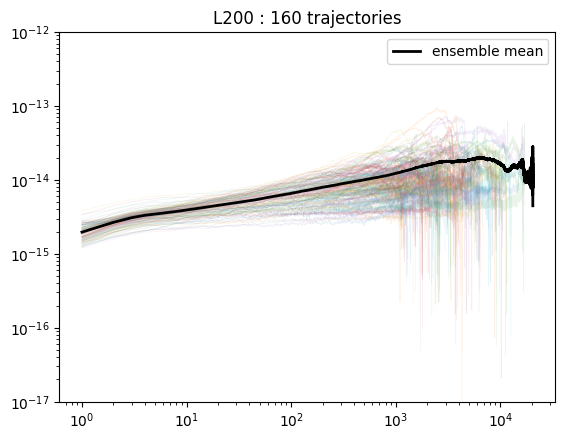

L250 124


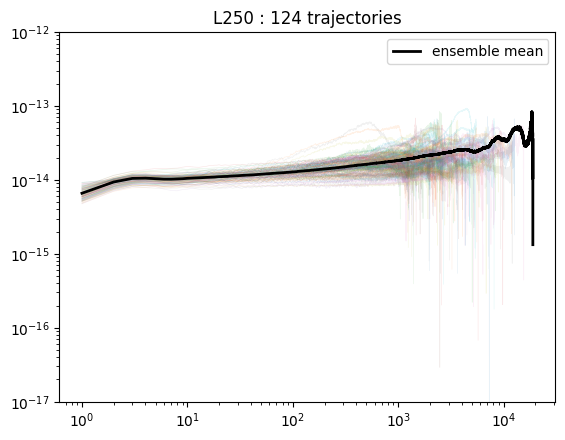

In [12]:
for cond in conditions:
    data_valid.makeSelection(cond)
    print(cond, len(data_valid))

    nl.plot.msd_overview(data_valid, linewidth=0.5, alpha=0.1)
    plt.title(f'{cond} : {len(data_valid)} trajectories')
    plt.ylim([1e-17, 1e-12])
    plt.show()

     L30: 142 trajectories
     L40: 157 trajectories
    L100: 193 trajectories
    L150: 159 trajectories
    L175: 150 trajectories
    L200: 160 trajectories
    L250: 124 trajectories


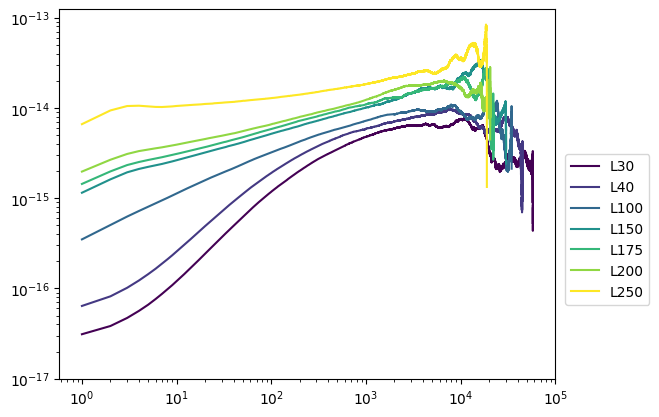

In [13]:
for cond in conditions:
    data_valid.makeSelection(cond)
    print(f'{cond:>8s}: {len(data_valid):>3d} trajectories')
    
    msd = nl.analysis.MSD(data_valid)
    plt.plot(np.arange(1, len(msd)), msd[1:], label=cond, color=colors[cond])
    
plt.legend(loc=(1.02, 0.2))
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-17, None])
plt.show()

In [14]:
data_valid.makeSelection()
nl.io.write.hdf5({
    'data' : data_valid,
    'conditions' : conditions,
    'description' : """
Cleaned-up MINFLUX H2B L-sweep data

L = 30, 40 from 2024-06
L = 100, 150, 175, 200, 250 from 2024-08

Cleaning was done by cutting before the first and after the last median-crossing

System is U2OS, untreated
"""[1:-1]}, '../data/20250302_minflux_L-sweep_clean.h5')